1. Import bibliotek i wczytanie danych

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os
from scipy.stats import normaltest, chi2_contingency, mannwhitneyu
import statsmodels.api as sm

# Wczytanie danych
df = pd.read_csv('../data/processed/Chicago_Crimes_2012_to_2017_processed.csv')
df['Date'] = pd.to_datetime(df['Date'])

2. Podstawowe statystyki opisowe

In [4]:
def calculate_basic_stats(df):
    # Statystyki numeryczne
    numeric_stats = df.select_dtypes(include=[np.number]).describe()

    # Miary centralne i rozproszenia dla głównych zmiennych
    crime_counts = df['Primary Type'].value_counts()
    location_counts = df['Location Description'].value_counts()

    print("Podstawowe statystyki dla zmiennych numerycznych:")
    print(numeric_stats)
    print("\nNajczęstsze typy przestępstw:")
    print(crime_counts.head())
    print("\nNajczęstsze lokalizacje:")
    print(location_counts.head())

    return numeric_stats, crime_counts, location_counts

# Wywołanie funkcji
numeric_stats, crime_counts, location_counts = calculate_basic_stats(df)

Podstawowe statystyki dla zmiennych numerycznych:
                 ID          Beat      District          Ward  Community Area  \
count  1.456714e+06  1.456714e+06  1.456713e+06  1.456700e+06    1.456674e+06   
mean   9.597550e+06  1.150644e+03  1.125920e+01  2.287027e+01    3.745632e+01   
std    8.083505e+05  6.916466e+02  6.904691e+00  1.380589e+01    2.144029e+01   
min    2.022400e+04  1.110000e+02  1.000000e+00  1.000000e+00    0.000000e+00   
25%    9.002709e+06  6.130000e+02  6.000000e+00  1.000000e+01    2.300000e+01   
50%    9.605776e+06  1.024000e+03  1.000000e+01  2.300000e+01    3.200000e+01   
75%    1.022577e+07  1.711000e+03  1.700000e+01  3.400000e+01    5.600000e+01   
max    1.082788e+07  2.535000e+03  3.100000e+01  5.000000e+01    7.700000e+01   

           Latitude     Longitude          Year         Month           Day  \
count  1.419631e+06  1.419631e+06  1.456714e+06  1.456714e+06  1.456714e+06   
mean   4.184147e+01 -8.767224e+01  2.013897e+03  6.511781e+00 

3. Analiza rozkładu danych

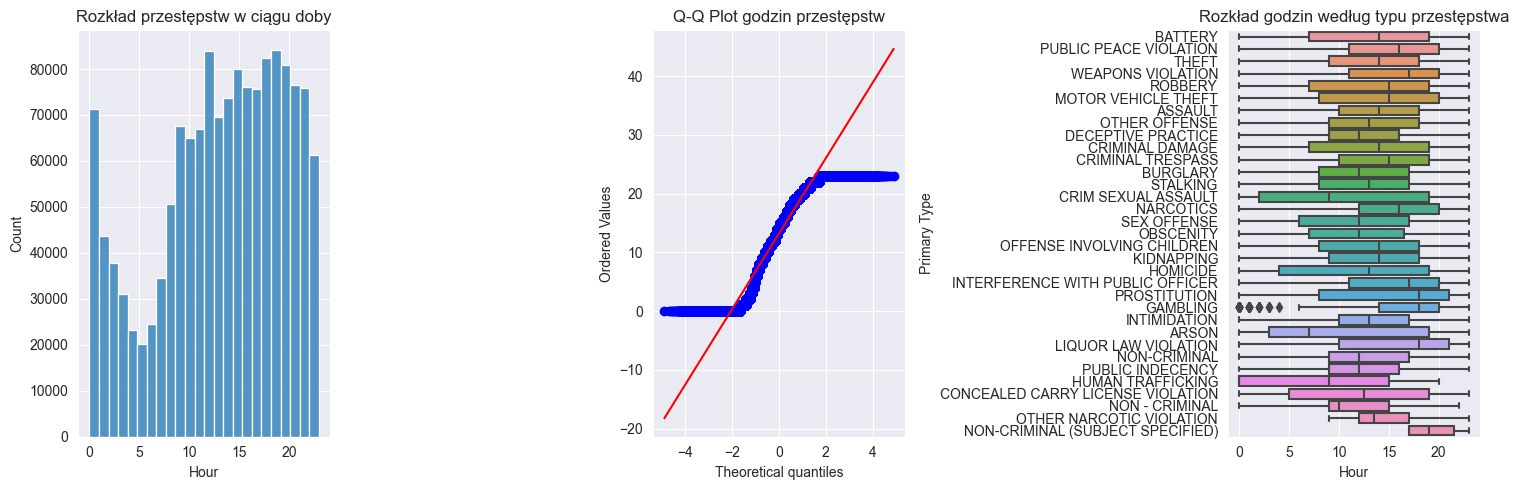

In [5]:
def analyze_distributions(df):
    plt.figure(figsize=(15, 5))

    # Rozkład przestępstw w czasie (godziny)
    plt.subplot(131)
    sns.histplot(data=df, x='Hour', bins=24)
    plt.title('Rozkład przestępstw w ciągu doby')

    # QQ plot dla godzin
    plt.subplot(132)
    stats.probplot(df['Hour'], dist="norm", plot=plt)
    plt.title('Q-Q Plot godzin przestępstw')

    # Box plot dla godzin według typu przestępstwa
    plt.subplot(133)
    sns.boxplot(data=df, y='Primary Type', x='Hour')
    plt.title('Rozkład godzin według typu przestępstwa')
    plt.tight_layout()
    plt.show()

analyze_distributions(df)

4. Testy normalności

In [6]:
def perform_normality_tests(df):
    print("Test normalności D'Agostino-Pearson dla godzin przestępstw:")
    statistic, p_value = normaltest(df['Hour'])
    print(f"Statystyka testowa: {statistic:.4f}")
    print(f"Wartość p: {p_value:.4f}")

    if p_value < 0.05:
        print("Rozkład istotnie różni się od normalnego")
    else:
        print("Nie ma podstaw do odrzucenia hipotezy o normalności rozkładu")

perform_normality_tests(df)

Test normalności D'Agostino-Pearson dla godzin przestępstw:
Statystyka testowa: 154005.1420
Wartość p: 0.0000
Rozkład istotnie różni się od normalnego


5. Analiza zależności między zmiennymi

In [7]:
def analyze_relationships(df):
    # Test chi-kwadrat dla zależności między typem przestępstwa a aresztowaniem
    contingency_table = pd.crosstab(df['Primary Type'], df['Arrest'])
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)

    print("Test chi-kwadrat dla zależności typ przestępstwa - aresztowanie:")
    print(f"Statystyka chi-kwadrat: {chi2:.4f}")
    print(f"Wartość p: {p_value:.4f}")
    print(f"Stopnie swobody: {dof}")

    # Współczynnik V Cramera
    n = len(df)
    min_dim = min(contingency_table.shape) - 1
    cramer_v = np.sqrt(chi2 / (n * min_dim))
    print(f"Współczynnik V Cramera: {cramer_v:.4f}")

    return chi2, p_value, cramer_v

chi2, p_value, cramer_v = analyze_relationships(df)

Test chi-kwadrat dla zależności typ przestępstwa - aresztowanie:
Statystyka chi-kwadrat: 627402.2475
Wartość p: 0.0000
Stopnie swobody: 32
Współczynnik V Cramera: 0.6563


6. Analiza korelacji dla zmiennych czasowych

/var/folders/49/k9_zjrf568l0hpq08flqcp5m0000gn/T/ipykernel_88821/750840553.py:15: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(122)
/Users/lukaszprzybysz/PycharmProjects/PythonProject/venv/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


ValueError: Can only compute partial correlations for lags up to 50% of the sample size. The requested nlags 23 must be < 12.

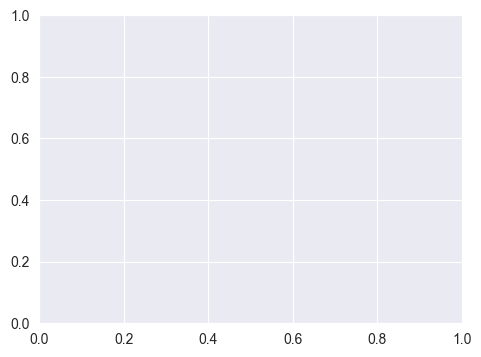

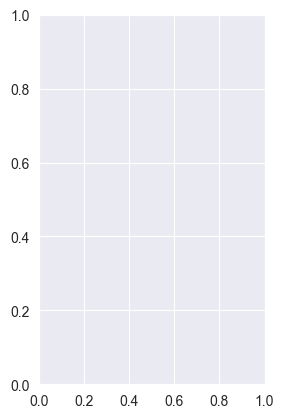

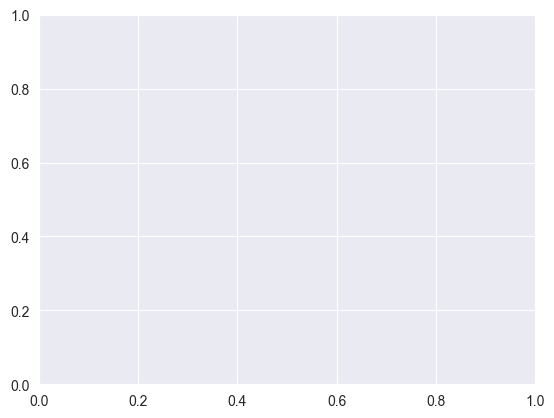

In [8]:
def analyze_time_correlations(df):
    # Przygotowanie danych czasowych
    df['Hour_sin'] = np.sin(2 * np.pi * df['Hour']/24)
    df['Hour_cos'] = np.cos(2 * np.pi * df['Hour']/24)

    # Grupowanie według godzin
    hourly_counts = df.groupby('Hour').size()

    # Analiza autokorelacji
    plt.figure(figsize=(12, 4))
    plt.subplot(121)
    sm.graphics.tsa.plot_acf(hourly_counts, lags=23)
    plt.title('Funkcja autokorelacji')

    plt.subplot(122)
    sm.graphics.tsa.plot_pacf(hourly_counts, lags=23)
    plt.title('Funkcja częściowej autokorelacji')
    plt.tight_layout()
    plt.show()

analyze_time_correlations(df)

7. Analiza wariancji (ANOVA) dla różnych kategorii

In [9]:
def perform_anova_analysis(df):
    # Przygotowanie danych do ANOVA
    crime_types = df['Primary Type'].value_counts().head(5).index
    df_subset = df[df['Primary Type'].isin(crime_types)]

    # Przeprowadzenie testu ANOVA
    crime_groups = [group['Hour'].values for name, group in df_subset.groupby('Primary Type')]
    f_statistic, p_value = stats.f_oneway(*crime_groups)

    print("\nJednokierunkowa ANOVA dla godzin według typu przestępstwa:")
    print(f"Statystyka F: {f_statistic:.4f}")
    print(f"Wartość p: {p_value:.4f}")

    # Analiza post-hoc (Tukey's test)
    from statsmodels.stats.multicomp import pairwise_tukeyhsd
    tukey = pairwise_tukeyhsd(endog=df_subset['Hour'],
                             groups=df_subset['Primary Type'],
                             alpha=0.05)
    print("\nTest post-hoc Tukeya:")
    print(tukey)

perform_anova_analysis(df)


Jednokierunkowa ANOVA dla godzin według typu przestępstwa:
Statystyka F: 3567.1897
Wartość p: 0.0000

Test post-hoc Tukeya:
         Multiple Comparison of Means - Tukey HSD, FWER=0.05         
     group1          group2     meandiff p-adj  lower   upper  reject
---------------------------------------------------------------------
        ASSAULT         BATTERY  -0.9253   0.0 -0.9939 -0.8568   True
        ASSAULT CRIMINAL DAMAGE  -0.7597   0.0 -0.8341 -0.6852   True
        ASSAULT       NARCOTICS   1.5487   0.0  1.4723  1.6252   True
        ASSAULT           THEFT  -0.4217   0.0 -0.4885 -0.3549   True
        BATTERY CRIMINAL DAMAGE   0.1656   0.0  0.1085  0.2227   True
        BATTERY       NARCOTICS   2.4741   0.0  2.4144  2.5338   True
        BATTERY           THEFT   0.5036   0.0  0.4569  0.5502   True
CRIMINAL DAMAGE       NARCOTICS   2.3084   0.0  2.2421  2.3748   True
CRIMINAL DAMAGE           THEFT    0.338   0.0   0.283  0.3929   True
      NARCOTICS           THEFT  -1

8. Podsumowanie analizy statystycznej

In [10]:
def generate_statistical_summary(df, chi2, p_value, cramer_v):
    summary = """
    Podsumowanie analizy statystycznej:

    1. Podstawowe statystyki:
    - Liczba obserwacji: {n}
    - Liczba unikalnych typów przestępstw: {unique_crimes}
    - Średnia godzina przestępstw: {mean_hour:.2f}

    2. Testy statystyczne:
    - Test normalności: rozkład godzin {normality}
    - Test chi-kwadrat (typ przestępstwa vs aresztowanie):
      * Chi-kwadrat: {chi2:.2f}
      * Wartość p: {p_value:.4f}
      * Współczynnik V Cramera: {cramer_v:.4f}

    3. Wnioski:
    - {normality_conclusion}
    - {dependency_conclusion}
    - {correlation_conclusion}
    """

    # Sprawdzenie normalności
    _, norm_p_value = normaltest(df['Hour'])
    normality = "nie jest normalny" if norm_p_value < 0.05 else "może być normalny"

    # Przygotowanie wniosków
    normality_conclusion = "Rozkład godzin przestępstw istotnie różni się od normalnego" if norm_p_value < 0.05 else "Rozkład godzin może być zbliżony do normalnego"
    dependency_conclusion = "Istnieje istotna zależność między typem przestępstwa a aresztowaniem" if p_value < 0.05 else "Nie wykryto istotnej zależności między typem przestępstwa a aresztowaniem"
    correlation_conclusion = f"Siła związku między zmiennymi jest {'słaba' if cramer_v < 0.3 else 'umiarkowana' if cramer_v < 0.5 else 'silna'}"

    return summary.format(
        n=len(df),
        unique_crimes=df['Primary Type'].nunique(),
        mean_hour=df['Hour'].mean(),
        normality=normality,
        chi2=chi2,
        p_value=p_value,
        cramer_v=cramer_v,
        normality_conclusion=normality_conclusion,
        dependency_conclusion=dependency_conclusion,
        correlation_conclusion=correlation_conclusion
    )

print(generate_statistical_summary(df, chi2, p_value, cramer_v))


    Podsumowanie analizy statystycznej:

    1. Podstawowe statystyki:
    - Liczba obserwacji: 1456714
    - Liczba unikalnych typów przestępstw: 33
    - Średnia godzina przestępstw: 13.20

    2. Testy statystyczne:
    - Test normalności: rozkład godzin nie jest normalny
    - Test chi-kwadrat (typ przestępstwa vs aresztowanie):
      * Chi-kwadrat: 627402.25
      * Wartość p: 0.0000
      * Współczynnik V Cramera: 0.6563

    3. Wnioski:
    - Rozkład godzin przestępstw istotnie różni się od normalnego
    - Istnieje istotna zależność między typem przestępstwa a aresztowaniem
    - Siła związku między zmiennymi jest silna
    
